# Solver-aided Language SMT2 Benchmark

Loading the dependencies

In [2]:
%load_ext autoreload
%autoreload 2

import time
import os
import glob
from joblib import Parallel, delayed
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from msbase.utils import load_json
import pickle
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm

import sys
sys.path.append("./code")


from tokenizer import bow
from util import *
import multiprocessing

# NOTE: be conservative and don't use all CPUs
ncpus = multiprocessing.cpu_count() - 1
ncpus

15

In [3]:
df_durations = pickle.load(open("df_durations.p", "rb"))
df_durations

,app,z3,cvc4,boolector,src,idxmin,min
f,,,,,,,
cosette_rosette_smt2/rosette15748107931574810793435_0.clean.smt2,Cosette,0.37,0.978381,5.74255,Cosette/rosette/neudbclass/wfea1.rkt,z3,0.370000
cosette_rosette_smt2/rosette15748108121574810812674_0.clean.smt2,Cosette,3.49,4.11495,20.2429,Cosette/rosette/cidr-benchmarks/pgsql-bug.rkt,z3,3.490000
cosette_rosette_smt2/rosette15748108171574810817765_0.clean.smt2,Cosette,0.13,0.517658,1.47891,Cosette/rosette/cidr-benchmarks/mutant-1.rkt,z3,0.130000
cosette_rosette_smt2/rosette15748109101574810910455_0.clean.smt2,Cosette,0.03,0.0330082,0.102851,Cosette/rosette/cidr-benchmarks/mutant-2.rkt,z3,0.030000
cosette_rosette_smt2/rosette15748109101574810910455_1.clean.smt2,Cosette,0.03,0.0500475,0.0926418,Cosette/rosette/cidr-benchmarks/mutant-2.rkt,z3,0.030000
...,...,...,...,...,...,...,...
cozy_lsort/cozy_dumped_0bdaed857c1d60dc.smt2,lsort,0.02,0.00533069,0.0611415,cozy/examples/lsort.ds,cvc4,0.005331
cozy_lsort/cozy_dumped_1ddb917ba3b39e52.smt2,lsort,0.02,0.0119939,0.0334404,cozy/examples/lsort.ds,cvc4,0.011994
cozy_lsort/cozy_dumped_7f6b2d2a71b15730.smt2,lsort,0.02,0.00488979,0.0451801,cozy/examples/lsort.ds,cvc4,0.004890


In [4]:
df_durations.groupby("idxmin").size()

idxmin
boolector     363
cvc4          425
z3           3129
dtype: int64

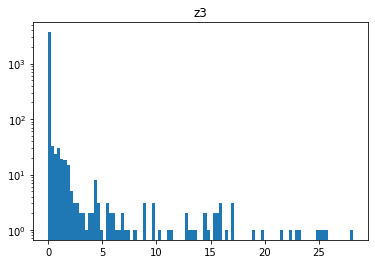

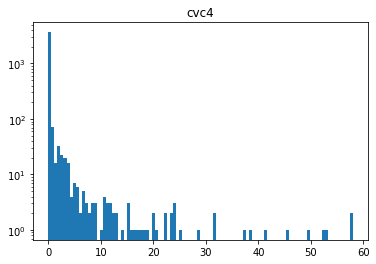

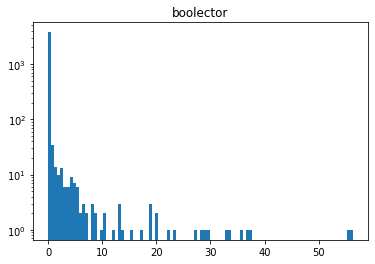

<Figure size 432x288 with 0 Axes>

In [5]:
for s in solvers.keys():
    plt.hist(df_durations[s], log=True, bins=100)
    plt.title(s)
    plt.show()
    plt.clf()

In [6]:
def unique_agg(xs):
    xs_set = set(xs)
    assert len(xs_set) == 1
    return xs[0]

def sum_nonena(xs):
    ys = [ x for x in xs if x is not None and not np.isnan(x) ]
    if len(ys):
        return sum(ys)
    return None

In [7]:
def reduce_dim(df):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    ret = pd.DataFrame(data=principalComponents, columns = ['principal component 1', 'principal component 2'])
    ret.index = df.index
    return ret

In [8]:
def plot_df_with_labels(principalDf, labels, save_to: str = None):
    cols = principalDf.columns
    assert len(cols) == 2
    plt.xlabel(cols[0], fontsize = 15)
    plt.ylabel(cols[1], fontsize = 15)
    for label in set(labels):
        plt.scatter(principalDf[labels == label][cols[0]]
                    , principalDf[labels == label][cols[1]]
                    , s = 10
                    , label = label)
    plt.legend()
    if save_to:
        plt.savefig(save_to)

Embed SMT2 and Racket files

In [9]:
datasets = {}
def update_dataset(name, X, Y):
    assert X.shape[0] == Y.shape[0], (X.shape[0], Y.shape[0])
    datasets[name] = (X, Y)

In [10]:
bow_smt2 = {}
bow_smt2 = dict(Parallel(n_jobs=ncpus)(delayed(lambda f: (f, bow("data/" + f)))(f) for f in df_durations.index))

smt2_embeddings = pd.DataFrame.from_dict(bow_smt2, orient="index")
smt2_embeddings_2d = reduce_dim(smt2_embeddings)
smt2_embeddings_2d

,principal component 1,principal component 2
cosette_rosette_smt2/rosette15748107931574810793435_0.clean.smt2,-2212.946957,-127.861031
cosette_rosette_smt2/rosette15748108121574810812674_0.clean.smt2,-439.430028,58.404265
cosette_rosette_smt2/rosette15748108171574810817765_0.clean.smt2,-2087.118223,-114.070052
cosette_rosette_smt2/rosette15748109101574810910455_0.clean.smt2,-2180.233785,-122.612241
cosette_rosette_smt2/rosette15748109101574810910455_1.clean.smt2,-2180.233785,-122.612241
...,...,...
cozy_lsort/cozy_dumped_0bdaed857c1d60dc.smt2,-2309.741796,-126.215573
cozy_lsort/cozy_dumped_1ddb917ba3b39e52.smt2,-2293.049665,-129.739711
cozy_lsort/cozy_dumped_7f6b2d2a71b15730.smt2,-2304.185079,-127.419728
cozy_lsort/cozy_dumped_81beee5aad87e260.smt2,-2304.185081,-127.419741


In [11]:
update_dataset("smt2_full", smt2_embeddings.loc[df_durations.index,:], df_durations)
update_dataset("smt2_2d", smt2_embeddings_2d.loc[df_durations.index,:], df_durations)

In [12]:
df_rkt_durations = df_durations.groupby(["src"]).agg(z3=pd.NamedAgg(column="z3", aggfunc=sum_nonena),
                                                     cvc4=pd.NamedAgg(column="cvc4", aggfunc=sum_nonena),
                                                     boolector=pd.NamedAgg(column="boolector", aggfunc=sum_nonena),
                                                     app=pd.NamedAgg(column="app", aggfunc=unique_agg))
df_rkt_durations["idxmin"] = df_rkt_durations[list(solvers.keys())].astype(float).idxmin(axis=1)
df_rkt_durations["min"] = df_rkt_durations[list(solvers.keys())].astype(float).min(axis=1)
df_rkt_durations

,z3,cvc4,boolector,app,idxmin,min
src,,,,,,
Cosette/rosette/cidr-benchmarks/final-exam-4.rkt,1.52,37.116693,18.949023,Cosette,z3,1.520000
Cosette/rosette/cidr-benchmarks/mutant-1.rkt,0.13,0.517658,1.478913,Cosette,z3,0.130000
Cosette/rosette/cidr-benchmarks/mutant-2.rkt,0.06,0.083056,0.195493,Cosette,z3,0.060000
Cosette/rosette/cidr-benchmarks/mutant-3.rkt,0.09,0.107149,0.300361,Cosette,z3,0.090000
Cosette/rosette/cidr-benchmarks/pgsql-bug-super-simplified.rkt,0.03,0.014296,0.078873,Cosette,cvc4,0.014296
Cosette/rosette/cidr-benchmarks/pgsql-bug.rkt,3.49,4.114954,20.242942,Cosette,z3,3.490000
Cosette/rosette/neudbclass/wfea1.rkt,0.37,0.978381,5.742554,Cosette,z3,0.370000
Cosette/rosette/tests/util-test.rkt,0.19,0.597894,0.571330,Cosette,z3,0.190000
cozy/examples/agg.ds,1.18,1.253386,2.119972,agg,z3,1.180000


In [13]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

docs = []
i_rkt_pairs = list(enumerate(df_rkt_durations.index.tolist()))
i_rkt_pairs
for i, rkt in i_rkt_pairs:
    docs.append(TaggedDocument(tokenize_doc("data/" + rkt), [i]))

model = Doc2Vec(docs, vector_size=64, min_count=2, epochs=40)
rkt_embeddings = pd.DataFrame.from_dict({ rkt : model.docvecs[i] for i, rkt in i_rkt_pairs }, orient="index")
rkt_embeddings_2d = reduce_dim(rkt_embeddings)
rkt_embeddings_2d

,principal component 1,principal component 2
Cosette/rosette/cidr-benchmarks/final-exam-4.rkt,-4.616568,-3.911933
Cosette/rosette/cidr-benchmarks/mutant-1.rkt,-3.807006,-3.586782
Cosette/rosette/cidr-benchmarks/mutant-2.rkt,-3.198270,-3.577633
Cosette/rosette/cidr-benchmarks/mutant-3.rkt,-3.408777,-3.668111
Cosette/rosette/cidr-benchmarks/pgsql-bug-super-simplified.rkt,-11.207446,1.957130
Cosette/rosette/cidr-benchmarks/pgsql-bug.rkt,-12.517694,2.045193
Cosette/rosette/neudbclass/wfea1.rkt,-4.474262,-4.616188
Cosette/rosette/tests/util-test.rkt,-3.313098,-1.420239
cozy/examples/agg.ds,-0.778748,-3.081967
cozy/examples/basic.ds,-0.776202,-2.378153


In [14]:
update_dataset("rkt_full", rkt_embeddings, df_rkt_durations)
update_dataset("rkt_2d", rkt_embeddings_2d, df_rkt_durations)

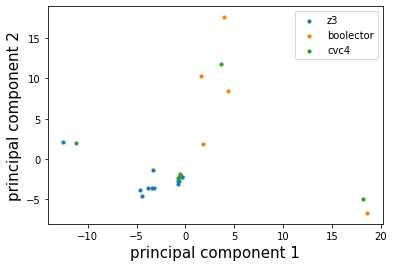

In [15]:
plot_df_with_labels(rkt_embeddings_2d, df_rkt_durations["idxmin"], "../fantastic-octo-paper/figures/racket-embedding-min.pdf")

## Difference of app in solver backend preference

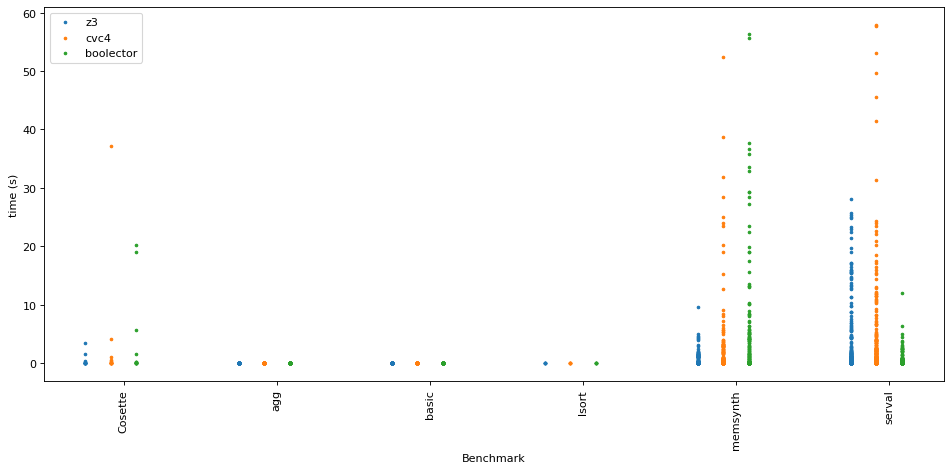

In [16]:
plt.figure(figsize=(12, 6), dpi=80)
apps = sorted(list(set([d["app"] for _, d in df_durations.iterrows()])))
for i, tool in enumerate(solvers):
    app_tool = df_durations[~df_durations[tool].isna()][["app", tool]]
    delta_x = (i - len(solvers) / 2.0) / (len(solvers) * 2)
    xs = [ x + delta_x for x in app_tool["app"].apply(lambda app: apps.index(app))]
    ys = app_tool[tool]
    plt.scatter(xs, ys, label=tool, s=5)
plt.legend()
plt.xticks(range(len(apps)), apps, rotation=90)
plt.xlabel("Benchmark")
plt.ylabel("time (s)")
plt.tight_layout()

## Speedups

In [17]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

In [18]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [19]:
import time

clf_names = ["rf", "linearsvc", "ada", "xgb"]

def get_clf(name):
    assert name in clf_names
    if   name == "rf":        return RandomForestClassifier(n_estimators=50, n_jobs=ncpus)
    elif name == "linearsvc": return LinearSVC(C=0.8, max_iter=10000)
    elif name == "xgb":       return XGBClassifier(n_jobs=ncpus)
    elif name == "ada":       return AdaBoostClassifier(n_estimators=50)

def calc_speedup(y_test, y_pred):
    df = pd.DataFrame(classification_report(y_test["idxmin"], y_pred, output_dict=True))
    sum_duration_pred = sum(y_test.loc[y_pred == solver, solver].sum() for solver in set(y_pred))
    return { s : (y_test[s].sum() / sum_duration_pred) for s in solvers.keys() }
    
def clf_task(clf_name, X, Y, test_size=0.7):
    print("clf_task(%s)" % clf_name)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    clf = get_clf(clf_name)
    now = time.time()
    clf.fit(X_train, y_train["idxmin"])
    y_pred = clf.predict(X_test)
    classification_report(y_pred=y_pred, y_true=y_test["idxmin"])
    return clf_name, calc_speedup(y_test, y_pred), clf, y_test

def test_classification_for_rkt_embedding(emb, df_durations_emb, n_repeat=100):
    assert emb.shape[0] == df_durations_emb.shape[0]
    print(emb.shape)
    ret = {}
    tasks = [(clf_name, emb.copy(), df_durations_emb.copy()) for _ in range(n_repeat) for clf_name in clf_names ]
    print("tasks: %s" % len(tasks))
#     all_results = Parallel(n_jobs=ncpus)(delayed(clf_task)(*args) for args in tqdm(tasks))
    all_results = [ clf_task(*args) for args in tasks ]
    all_results_folded = {}
    for clf_name, result, _, _ in all_results:
        if clf_name not in all_results_folded:
            all_results_folded[clf_name] = []
        all_results_folded[clf_name].append(result)
    for clf_name, results in all_results_folded.items():
        ret[clf_name] = { s : geo_mean([ r[s] for r in results ]) for s in solvers.keys() }
    return pd.DataFrame.from_dict(ret).round(2)

In [20]:
emb = smt2_embeddings_2d.copy()
emb["rkt"] = df_durations["src"]
emb = emb.dropna()
emb["rkt pc1"] = rkt_embeddings_2d.loc[emb["rkt"], "principal component 1"].tolist()
emb["rkt pc2"] = rkt_embeddings_2d.loc[emb["rkt"], "principal component 2"].tolist()
smt2_rkt_embeddings_2d = emb.drop(columns=["rkt"]).rename(columns={"principal component 1": "smt2 pc1", "principal component 2": "smt2 pc2"})

df_durations_emb = df_durations.dropna(subset=["src"])
update_dataset("smt2_rkt_2d", smt2_rkt_embeddings_2d, df_durations_emb)

In [21]:
emb = smt2_embeddings.copy()
emb["rkt"] = df_durations["src"]
emb = emb.dropna()
rkt_embeddings2 = rkt_embeddings.loc[emb["rkt"], :]
rkt_embeddings2["smt2"] = emb.index
rkt_embeddings2 = rkt_embeddings2.set_index("smt2")
rkt_embeddings2 = rkt_embeddings2.rename(columns={ c : ("rkt_%s" % c) for c in rkt_embeddings2.columns })
emb = pd.concat([emb, rkt_embeddings2], axis=1, sort=False)
smt2_rkt_embeddings = emb.drop(columns=["rkt"])

df_durations_emb = df_durations.dropna(subset=["src"])
update_dataset("smt2_rkt_full", smt2_rkt_embeddings, df_durations_emb)

In [22]:
benchmark_results = {}
for name, XY in datasets.items():
    print(name)
    X, Y = XY
    if X.shape[0] < 50:
        continue
    df_ret = test_classification_for_rkt_embedding(X, Y, n_repeat = 1)
    benchmark_results[name] = df_ret
for name, df in benchmark_results.items():
    print(name)
    print(df)

smt2_full
(3917, 59)
tasks: 4
clf_task(rf)
clf_task(linearsvc)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


clf_task(ada)
clf_task(xgb)
smt2_2d
(3917, 2)
tasks: 4
clf_task(rf)
clf_task(linearsvc)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf_task(ada)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf_task(xgb)
rkt_full
rkt_2d
smt2_rkt_2d
(3917, 4)
tasks: 4
clf_task(rf)
clf_task(linearsvc)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf_task(ada)
clf_task(xgb)
smt2_rkt_full
(3917, 123)
tasks: 4
clf_task(rf)
clf_task(linearsvc)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


clf_task(ada)
clf_task(xgb)
smt2_full
             rf  linearsvc   ada   xgb
z3         3.39       1.18  1.66  3.65
cvc4       5.79       1.97  3.02  7.43
boolector  4.06       1.21  1.69  4.34
smt2_2d
             rf  linearsvc   ada   xgb
z3         2.95       1.82  1.02  2.20
cvc4       5.01       3.06  2.02  4.04
boolector  3.19       1.98  1.19  2.55
smt2_rkt_2d
             rf  linearsvc   ada   xgb
z3         2.90       1.03  0.70  2.98
cvc4       5.29       2.04  1.32  5.60
boolector  3.30       1.25  0.86  3.46
smt2_rkt_full
             rf  linearsvc   ada   xgb
z3         3.39       1.74  3.55  3.97
cvc4       6.56       3.16  6.48  7.23
boolector  3.69       1.99  4.40  3.93


In [23]:
df = pd.DataFrame()
for col in benchmark_results.keys():
    df[col] = benchmark_results[col].max(axis=1).map(str) + " (" + benchmark_results[col].idxmax(axis=1) + ")"
df

,smt2_full,smt2_2d,smt2_rkt_2d,smt2_rkt_full
z3,3.65 (xgb),2.95 (rf),2.98 (xgb),3.97 (xgb)
cvc4,7.43 (xgb),5.01 (rf),5.6 (xgb),7.23 (xgb)
boolector,4.34 (xgb),3.19 (rf),3.46 (xgb),4.4 (ada)


In [34]:
%%capture

def run_task():
    X, Y = datasets["rkt_full"]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5)

    from sklearn.cluster import DBSCAN, KMeans

    # clf = DBSCAN(eps=.9)
    clf = KMeans(n_clusters=4)
    trained_clusters = clf.fit_predict(X_train)
    clf_clusters = {}
    for i in set(trained_clusters):
        X_train_sub = X_train[trained_clusters == i]
        clf_i = XGBClassifier(n_jobs=ncpus)
        clf_i.fit(X_train_sub, y_train[trained_clusters == i]["idxmin"])
        clf_clusters[i] = clf_i

    predicted_clusters = clf.predict(X_test)
    y_pred = pd.DataFrame(np.ndarray(y_test["idxmin"].shape), columns=["pred"]).astype(str)
    for i in set(predicted_clusters):
        X_predicted_sub = X_test[predicted_clusters == i]
        y_predicted_sub = clf_clusters[i].predict(X_predicted_sub)
        y_pred.loc[predicted_clusters == i, "pred"] = y_predicted_sub
    pd.concat([y_pred, y_test["idxmin"].reset_index(drop=True)], axis=1)
    return calc_speedup(y_test, y_pred["pred"].values)

all_speedups = { "z3": [], "cvc4": [], "boolector": [] }
MAX_SAMPLES = 100
# results = Parallel(n_jobs=2)(delayed(run_task)() for _ in tqdm(range(MAX_SAMPLES)))
results = [ run_task() for _ in tqdm(range(MAX_SAMPLES))]

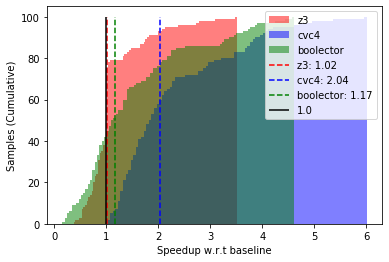

In [35]:
for k in all_speedups.keys():
    all_speedups[k] = [ r[k] for r in results ]
colors = {
    "z3": "red",
    "cvc4": "blue",
    "boolector": "green"
}
for name, speedups in all_speedups.items():
    plt.hist(speedups, bins=100, cumulative=True, alpha=0.5, label=name, color=colors[name])
    plt.vlines(geo_mean(speedups), 0, MAX_SAMPLES, label="%s: %.2f" % (name, geo_mean(speedups)), linestyle="--", color=colors[name])
plt.vlines(1.0, 0, MAX_SAMPLES, label="1.0", linestyle="-")
plt.legend()
plt.xlabel("Speedup w.r.t baseline")
plt.ylabel("Samples (Cumulative)")
plt.show()

## Embeddings of rkt for different apps

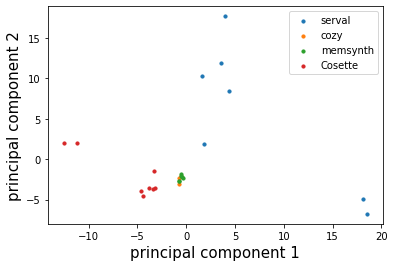

In [36]:
rkt_embeddings_2d_app = rkt_embeddings_2d.index.to_series().apply(lambda rkt: rkt.split("/")[0])

plot_df_with_labels(rkt_embeddings_2d, rkt_embeddings_2d_app)